In [1]:
# Step 1: Imports and Data Loading
import numpy as np
import pandas as pd
import ast
import pickle
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

# Merge on title
movies = movies.merge(credits, on='title')

# Keep relevant features
movies = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]
movies.dropna(inplace=True)

In [3]:
# Step 2: Data Cleaning and Preprocessing

# Convert stringified lists to actual Python lists
def convert(obj):
    L = []
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L

def convert3(obj):
    L = []
    count = 0
    for i in ast.literal_eval(obj):
        if count < 3:
            L.append(i['name'])
            count += 1
        else:
            break
    return L

def fetch_director(obj):
    L = []
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director':
            L.append(i['name'])
            break
    return L

# Apply conversions
movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)
movies['cast'] = movies['cast'].apply(convert3)
movies['crew'] = movies['crew'].apply(fetch_director)
movies['overview'] = movies['overview'].apply(lambda x: x.split())

# Remove spaces from multi-word names
for col in ['genres', 'keywords', 'cast', 'crew']:
    movies[col] = movies[col].apply(lambda x: [i.replace(" ", "") for i in x])

# Create tags column
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']
new_df = movies[['movie_id', 'title', 'tags']]
new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))


C:\Users\siddh\AppData\Local\Temp\ipykernel_39772\2232055535.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))


In [5]:
# Step 3: Text Vectorization and Similarity Computation

# Stemming
ps = PorterStemmer()
def stem(text):
    return " ".join([ps.stem(i) for i in text.split()])

new_df['tags'] = new_df['tags'].apply(lambda x: x.lower())
new_df['tags'] = new_df['tags'].apply(stem)

# Vectorize
cv = CountVectorizer(max_features=5000, stop_words='english')
vectors = cv.fit_transform(new_df['tags']).toarray()

# Cosine similarity
similarity = cosine_similarity(vectors)


C:\Users\siddh\AppData\Local\Temp\ipykernel_39772\1584964482.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x: x.lower())
C:\Users\siddh\AppData\Local\Temp\ipykernel_39772\1584964482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(stem)


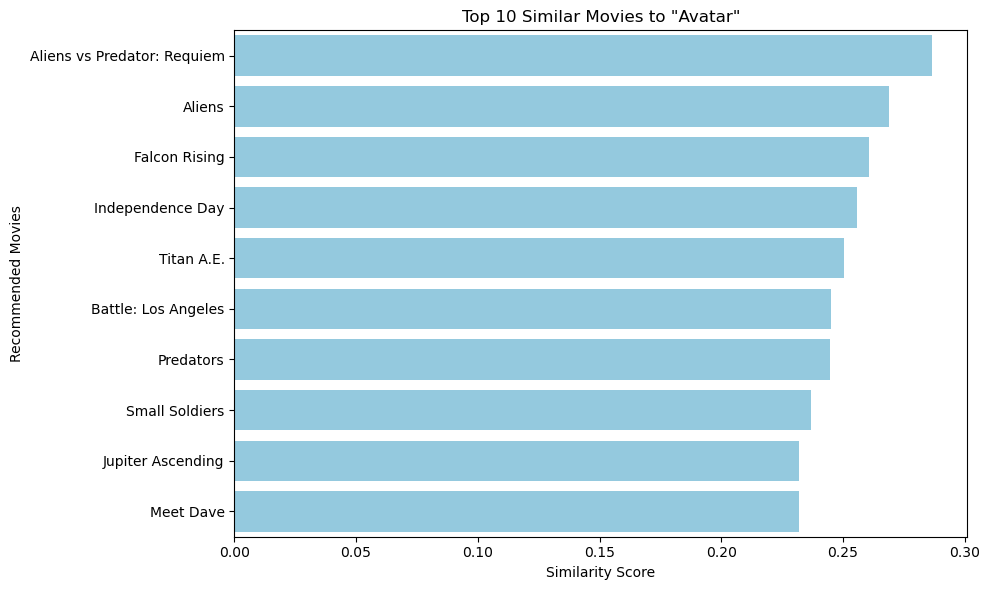

In [15]:
# Step 4: Visualization - Bar Chart of Top 10 Similar Movies

def plot_top_similarities(movie_name):
    if movie_name not in new_df['title'].values:
        print(f"Movie '{movie_name}' not found in dataset.")
        return
    
    idx = new_df[new_df['title'] == movie_name].index[0]
    distances = similarity[idx]
    sim_scores = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:11]
    movie_names = [new_df.iloc[i[0]].title for i in sim_scores]
    similarity_scores = [i[1] for i in sim_scores]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x=similarity_scores, y=movie_names, color='skyblue')  # Clean, future-proof
    plt.xlabel('Similarity Score')
    plt.ylabel('Recommended Movies')
    plt.title(f'Top 10 Similar Movies to \"{movie_name}\"')
    plt.tight_layout()
    plt.show()
plot_top_similarities("Avatar")


In [9]:
# Step 5: Save Model Files

# Save the dictionary and similarity matrix
pickle.dump(new_df.to_dict(), open('movie_dict.pkl', 'wb'))
pickle.dump(similarity, open('similarity.pkl', 'wb'))